In [ ]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers, losses, metrics
from keras import preprocessing
from keras.datasets import imdb
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, LSTM, Conv1D, GlobalMaxPool1D,Dropout,MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

크롤링내용 부분 한줄로 처리해서 데이터 수 늘리기

In [ ]:
path = "/content/drive/My Drive/쿠팡"
folder_list = os.listdir(path)
print ("folder_list: {}".format(folder_list))

folder_list: ['8.가전디지털', '5.주방용품', '14.반려동물용품', '3.출산유아동', '6.생활용품', '15.헬스건강식품', '7.홈인테리어', '4.식품', '9.스포츠레저', '2.뷰티', '12.완구취미', '1.패션의류잡화', '11.도서음반DVD', '10.자동차용품', '13.문구오피스']


In [ ]:
dd = pd.DataFrame(columns=['대분류','중분류','소분류','내용_x','내용_y'])
for k in range(len(folder_list)):
    path = "/content/drive/My Drive/쿠팡/{}".format(folder_list[k])
    file_list = os.listdir(path)
    for j in range(len(file_list)):
        data = pd.read_csv("{}/{}".format(path,file_list[j]))
        split = data.내용.str.split("', ")
        st = []
        for i in split:
          if len(i) >= 10:
            st.append(i)
        split = pd.Series(st)
        split = split.apply(lambda x: pd.Series(x))
        split.stack()
        split.stack().reset_index(level=1, drop=True)
        split = split.stack().reset_index(level=1, drop=True).to_frame('내용')
        dd = pd.concat([dd,data.merge(split, left_index=True, right_index=True, how='left')])

In [ ]:
dd.drop_duplicates(subset=['내용_y'], inplace=True) # 내용_y 열에서 중복인 내용이 있다면 중복 제거

In [ ]:
dd

,대분류,중분류,소분류,내용_x,내용_y,Unnamed: 0
0,가전디지털,휴대폰/액세서리,휴대폰,"['삼성전자 갤럭시 S20 FE, 공기계, 클라우드 라벤더, 128GB', '삼성전...","['삼성전자 갤럭시 S20 FE, 공기계, 클라우드 라벤더, 128GB",0.0
0,가전디지털,휴대폰/액세서리,휴대폰,"['삼성전자 갤럭시 S20 FE, 공기계, 클라우드 라벤더, 128GB', '삼성전...","'삼성전자 갤럭시 S20 FE, 공기계, 클라우드 레드, 128GB",0.0
0,가전디지털,휴대폰/액세서리,휴대폰,"['삼성전자 갤럭시 S20 FE, 공기계, 클라우드 라벤더, 128GB', '삼성전...","'Apple 2020년 iPad Pro 11 2세대, Wi-Fi, 128GB, Sp...",0.0
0,가전디지털,휴대폰/액세서리,휴대폰,"['삼성전자 갤럭시 S20 FE, 공기계, 클라우드 라벤더, 128GB', '삼성전...","'삼성전자 갤럭시 A31 휴대폰 SM-A315N, 공기계, 프리즘 크러시 블랙, 64GB",0.0
0,가전디지털,휴대폰/액세서리,휴대폰,"['삼성전자 갤럭시 S20 FE, 공기계, 클라우드 라벤더, 128GB', '삼성전...","'샤오미 홍미노트 9S 자급제 새상품 6+ 128GB, 공기계, 화이트",0.0
...,...,...,...,...,...,...
13,문구&오피스,보드_칠판_광고,기타매장/진열용품,"['금강칠판 탁상용 자석 화이트보드', '금강칠판 고급형 자석 화이트보드, 알루미늄...",'[2개묶음 할인]컬러 인덱스 명함케이스 명함보관집 쿠폰정리 JDF-57776 데스...,13.0
13,문구&오피스,보드_칠판_광고,기타매장/진열용품,"['금강칠판 탁상용 자석 화이트보드', '금강칠판 고급형 자석 화이트보드, 알루미늄...",'[2개묶음 할인]메모꽂이 POP집게-PG4004 집게 대형 POP꽂이 JDF-57...,13.0
13,문구&오피스,보드_칠판_광고,기타매장/진열용품,"['금강칠판 탁상용 자석 화이트보드', '금강칠판 고급형 자석 화이트보드, 알루미늄...",'[4개묶음 할인]색동 비단 누빔 펜슬케이스(5 colors) JDF-83095 펜...,13.0
13,문구&오피스,보드_칠판_광고,기타매장/진열용품,"['금강칠판 탁상용 자석 화이트보드', '금강칠판 고급형 자석 화이트보드, 알루미늄...",'사무용 수동 문서세단기 / 문서파쇄기,13.0


내용 컬럼의 값들을 영어, 숫자, 특수문자 등을 삭제한 한글 단어로 쪼개기

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

X_train = []
for sentence in dd['내용_y']:
    try:
      only_han = re.sub('[^가-힣]', ' ', sentence).split()
      print(only_han)
      X_train.append(only_han)
    except:
      X_train.append('')

In [ ]:
dd['내용'] = X_train

In [ ]:
del dd['Unnamed: 0'] #내용_x,내용_y,Unnamed: 0 삭제

In [ ]:
dd

,대분류,중분류,소분류,내용
0,가전디지털,휴대폰/액세서리,휴대폰,"[삼성전자, 갤럭시, 공기계, 클라우드, 라벤더]"
1,가전디지털,휴대폰/액세서리,휴대폰,"[삼성전자, 갤럭시, 공기계, 클라우드, 레드]"
2,가전디지털,휴대폰/액세서리,휴대폰,"[년, 세대]"
3,가전디지털,휴대폰/액세서리,휴대폰,"[삼성전자, 갤럭시, 휴대폰, 공기계, 프리즘, 크러시, 블랙]"
4,가전디지털,휴대폰/액세서리,휴대폰,"[샤오미, 홍미노트, 자급제, 새상품, 공기계, 화이트]"
...,...,...,...,...
643395,문구&오피스,보드_칠판_광고,기타매장/진열용품,"[개묶음, 할인, 컬러, 인덱스, 명함케이스, 명함보관집, 쿠폰정리, 데스크명함박스..."
643396,문구&오피스,보드_칠판_광고,기타매장/진열용품,"[개묶음, 할인, 메모꽂이, 집게, 집게, 대형, 꽂이, 깔끔한메모꽂이, 메모집게]"
643397,문구&오피스,보드_칠판_광고,기타매장/진열용품,"[개묶음, 할인, 색동, 비단, 누빔, 펜슬케이스, 펜슬파우치, 선물용필통, 비단필..."
643398,문구&오피스,보드_칠판_광고,기타매장/진열용품,"[사무용, 수동, 문서세단기, 문서파쇄기]"


크롤링 데이터 한 테이블로 합치기

In [ ]:
dc = pd.DataFrame(columns=['대분류','중분류','소분류','내용'])
for k in range(len(folder_list)):
    path = "/content/drive/My Drive/쿠팡/{}".format(folder_list[k])
    file_list = os.listdir(path)
    for j in range(len(file_list)):
        data = pd.read_csv("{}/{}".format(path,file_list[j]))
        dc = pd.concat([dc,data])

In [ ]:
del dc['Unnamed: 0']

In [ ]:
dc

,대분류,중분류,소분류,내용
0,가전디지털,휴대폰/액세서리,휴대폰,"['삼성전자 갤럭시 S20 FE, 공기계, 클라우드 라벤더, 128GB', '삼성전..."
1,가전디지털,휴대폰/액세서리,휴대폰 케이스,"['삼성전자 갤럭시 S20 FE, 공기계, 클라우드 라벤더, 128GB', '아라리..."
2,가전디지털,휴대폰/액세서리,휴대폰 액세서리,"['삼성전자 갤럭시 S20 FE, 공기계, 클라우드 라벤더, 128GB', '삼성전..."
3,가전디지털,휴대폰/액세서리,배터리/충전/케이블,"['삼성전자 갤럭시 S20 FE, 공기계, 클라우드 라벤더, 128GB', '삼성전..."
4,가전디지털,휴대폰/액세서리,스마트워치/밴드,"['삼성전자 갤럭시 S20 FE, 공기계, 클라우드 라벤더, 128GB', '삼성전..."
...,...,...,...,...
9,문구&오피스,보드_칠판_광고,쇼카드,"['금강칠판 탁상용 자석 화이트보드', '금강칠판 고급형 자석 화이트보드, 알루미늄..."
10,문구&오피스,보드_칠판_광고,아크릴꽂이/집게,"['금강칠판 탁상용 자석 화이트보드', '금강칠판 고급형 자석 화이트보드, 알루미늄..."
11,문구&오피스,보드_칠판_광고,아크릴사인/표지판,"['금강칠판 탁상용 자석 화이트보드', '금강칠판 고급형 자석 화이트보드, 알루미늄..."
12,문구&오피스,보드_칠판_광고,마네킹,"['금강칠판 탁상용 자석 화이트보드', '금강칠판 고급형 자석 화이트보드, 알루미늄..."


단어의 빈도수를 체크하여 사전 만들기

In [ ]:
path = "/content/drive/My Drive/쿠팡"
folder_list = os.listdir(path)
print ("folder_list: {}".format(folder_list))

folder_list: ['8.가전디지털', '5.주방용품', '14.반려동물용품', '3.출산유아동', '6.생활용품', '15.헬스건강식품', '7.홈인테리어', '4.식품', '9.스포츠레저', '2.뷰티', '12.완구취미', '1.패션의류잡화', '11.도서음반DVD', '10.자동차용품', '13.문구오피스']


In [ ]:
dic = []
for k in range(len(folder_list)):
    path = "/content/drive/My Drive/쿠팡/{}".format(folder_list[k])
    file_list = os.listdir(path)
    for j in range(len(file_list)):
        data = pd.read_csv("{}/{}".format(path,file_list[j]))
        txt = ''
        for i in range(len(data)):
          txt += data['내용'][i]
        only_han = re.sub('[^가-힣]', ' ', txt).split()
        word_list = pd.Series(only_han) #판다스 시리즈이용, 엑셀저장 준비
        result = word_list.value_counts() #단어별 빈도수 체크 (value_counts 이용)
        index = 0
        for k,v in result.items():
          if index <100:
            dic.append(k)
            index+=1
          else:
            break

set을 사용하여 dic의 중복된 값 제거

In [ ]:
set_dic = set(dic)

In [ ]:
set_dic = list(set_dic)

In [ ]:
word_table= pd.DataFrame.from_dict(tokenizer.word_index, orient='index')

In [ ]:
word_table.to_csv('단어사전.csv')

tokenizer를 사용하여 set_dic 값에 인덱스값을 지정하고, 단어로 쪼갠 내용들에 인덱스 값을 넣어줌

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(set_dic)
print(tokenizer.word_index)

{'버스': 1, '깔창': 2, '후드': 3, '표고버섯': 4, '수입': 5, '양면테이프': 6, '길': 7, '무릎': 8, '포대기': 9, '항아리': 10, '세차': 11, '제빙기': 12, '스타일': 13, '내츄럴': 14, '위너스': 15, '샴페인잔': 16, '하월시아': 17, '몽모랑시': 18, '개별': 19, '파나소닉': 20, '일러스트': 21, '대본집': 22, '야구': 23, '버터': 24, '권으로': 25, '카테킨': 26, '닥터자르트': 27, '앨범': 28, '유아웨건': 29, '머그컵': 30, '선택시': 31, '플레이도우': 32, '크로커다일레이디': 33, '물뿌리개': 34, '연구': 35, '수족관': 36, '베러': 37, '가구용': 38, '설화수': 39, '에뛰드하우스': 40, '촉촉한': 41, '순간': 42, '한국사능력검정시험': 43, '허벌라이프': 44, '유아변기': 45, '블럭마트': 46, '오프': 47, '이해와': 48, '이힝': 49, '구체관절인형': 50, '허브스미스': 51, '그린베베': 52, '메이크업': 53, '호박씨': 54, '에어팟프로': 55, '흑화고': 56, '사과': 57, '라벨': 58, '라이트': 59, '받침': 60, '뉴트로지나': 61, '큰글씨책': 62, '편한': 63, '백설공주': 64, '신축성': 65, '줄조명': 66, '로기블라인드': 67, '디딤대': 68, '회전형': 69, '농구공': 70, '그로미미': 71, '방수요': 72, '유니아트': 73, '양말': 74, '낱봉': 75, '부동산': 76, '주머니': 77, '노견': 78, '컨투어': 79, '쇼파커버': 80, '배변': 81, '밥친구': 82, '컵홀더': 83, '매직픽': 84, '질경이': 85, '보온보냉병': 86, '전연령': 87, '레인보우라이트': 88, '옵션': 89

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)

내용인덱스에 비어 있는 값들 행 제거

In [ ]:
dd = dd.reset_index()

In [ ]:
del dd['index']

In [ ]:
dd

,대분류,중분류,소분류,내용
0,가전디지털,휴대폰/액세서리,휴대폰,"[삼성전자, 갤럭시, 공기계, 클라우드, 라벤더]"
1,가전디지털,휴대폰/액세서리,휴대폰,"[삼성전자, 갤럭시, 공기계, 클라우드, 레드]"
2,가전디지털,휴대폰/액세서리,휴대폰,"[년, 세대]"
3,가전디지털,휴대폰/액세서리,휴대폰,"[삼성전자, 갤럭시, 휴대폰, 공기계, 프리즘, 크러시, 블랙]"
4,가전디지털,휴대폰/액세서리,휴대폰,"[샤오미, 홍미노트, 자급제, 새상품, 공기계, 화이트]"
...,...,...,...,...
643395,문구&오피스,보드_칠판_광고,기타매장/진열용품,"[개묶음, 할인, 컬러, 인덱스, 명함케이스, 명함보관집, 쿠폰정리, 데스크명함박스..."
643396,문구&오피스,보드_칠판_광고,기타매장/진열용품,"[개묶음, 할인, 메모꽂이, 집게, 집게, 대형, 꽂이, 깔끔한메모꽂이, 메모집게]"
643397,문구&오피스,보드_칠판_광고,기타매장/진열용품,"[개묶음, 할인, 색동, 비단, 누빔, 펜슬케이스, 펜슬파우치, 선물용필통, 비단필..."
643398,문구&오피스,보드_칠판_광고,기타매장/진열용품,"[사무용, 수동, 문서세단기, 문서파쇄기]"


In [ ]:
for i in range(len(dd)):
  if dd['내용'][i] == []:
    dd = dd.drop(i)

In [ ]:
dd

,대분류,중분류,소분류,내용
0,가전디지털,휴대폰/액세서리,휴대폰,"[삼성전자, 갤럭시, 공기계, 클라우드, 라벤더]"
1,가전디지털,휴대폰/액세서리,휴대폰,"[삼성전자, 갤럭시, 공기계, 클라우드, 레드]"
2,가전디지털,휴대폰/액세서리,휴대폰,"[년, 세대]"
3,가전디지털,휴대폰/액세서리,휴대폰,"[삼성전자, 갤럭시, 휴대폰, 공기계, 프리즘, 크러시, 블랙]"
4,가전디지털,휴대폰/액세서리,휴대폰,"[샤오미, 홍미노트, 자급제, 새상품, 공기계, 화이트]"
...,...,...,...,...
643395,문구&오피스,보드_칠판_광고,기타매장/진열용품,"[개묶음, 할인, 컬러, 인덱스, 명함케이스, 명함보관집, 쿠폰정리, 데스크명함박스..."
643396,문구&오피스,보드_칠판_광고,기타매장/진열용품,"[개묶음, 할인, 메모꽂이, 집게, 집게, 대형, 꽂이, 깔끔한메모꽂이, 메모집게]"
643397,문구&오피스,보드_칠판_광고,기타매장/진열용품,"[개묶음, 할인, 색동, 비단, 누빔, 펜슬케이스, 펜슬파우치, 선물용필통, 비단필..."
643398,문구&오피스,보드_칠판_광고,기타매장/진열용품,"[사무용, 수동, 문서세단기, 문서파쇄기]"


In [ ]:
dd = dd.reset_index()
del dd['index']

In [ ]:
X_train = dd['내용']
X_train = tokenizer.texts_to_sequences(X_train)

In [ ]:
dd['내용인덱스'] = X_train

In [ ]:
dd.to_csv('/content/drive/My Drive/내용인덱스.csv')

라벨값(중분류)을 원핫 인코딩해줌

In [ ]:
data = dd[['내용인덱스','중분류']]

In [ ]:
data

,내용인덱스,중분류
0,"[3876, 4958, 3475, 5504]",휴대폰/액세서리
1,"[3876, 4958, 3475, 104]",휴대폰/액세서리
2,"[2923, 6206]",휴대폰/액세서리
3,"[3876, 4958, 2672, 3475, 6692]",휴대폰/액세서리
4,"[1144, 3475, 3549]",휴대폰/액세서리
...,...,...
628993,"[6974, 1471, 3949, 3405]",보드_칠판_광고
628994,"[6974, 1471, 6208, 6208, 6051, 5894]",보드_칠판_광고
628995,"[6974, 1471, 2046, 4005]",보드_칠판_광고
628996,"[1561, 6118]",보드_칠판_광고


In [ ]:
one_hot_encoded = pd.get_dummies(data.중분류) 
onehot_data = pd.concat([data, one_hot_encoded],axis=1) 

In [ ]:
onehot_data

,내용인덱스,1인방송 전문관,F/W 침구샵,RC완구/부품,STEAM완구,TV/영상가전,가구,가루/조미료/오일,가방/잡화,가정 살림,강아지_영양제,강아지_용품,강아지간식,강아지사료,건강 취미,건강_의료용품,건강가전,건강도서,건강식품,건강즙,견과/건과,경제 경영,고양이_간식,고양이_사료,고양이_영양제,고양이_용품,골프,공구/철물/DIY,과일,과자/초콜릿/시리얼,과학/공학,관리/안전용품,관상어_용품,교자상/제수용품,구강/면도,구기스포츠,국어/외국어/사전,그릇/홈세트,기저귀,낚시,...,차량용 디지털,차량용디지털,채소,청소/주방세제,초중고참고서,축산/계란,침구,카드_엽서_봉투,카메라,카시트,카페트/쿠션/거실화,칼/도마,캐릭터_문구,캐릭터별완구,캠핑전문관,커튼/블라인드,커피/원두/차,커피/티/와인,컴퓨터,컵/잔/텀블러,콘솔/게이밍PC,클렌징/필링,킥보드/스케이트,탈취/방향/살충,파티_이벤트,퍼즐/큐브/피젯토이,프라모델,필기류,학습완구/교구,학용품_수업준비,향수,헤어,헬스/요가/댄스,헬스_요가용품,헬스보충식품,홈데코,홈트레이닝,홍삼_인삼,화장지/물티슈,휴대폰/액세서리
0,"[3876, 4958, 3475, 5504]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,"[3876, 4958, 3475, 104]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,"[2923, 6206]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,"[3876, 4958, 2672, 3475, 6692]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,"[1144, 3475, 3549]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628993,"[6974, 1471, 3949, 3405]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
628994,"[6974, 1471, 6208, 6208, 6051, 5894]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
628995,"[6974, 1471, 2046, 4005]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
628996,"[1561, 6118]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


내용인덱스의 길이 맞춰주기

리뷰의 최대 길이 : 118
리뷰의 평균 길이 : 4.2348306353915275


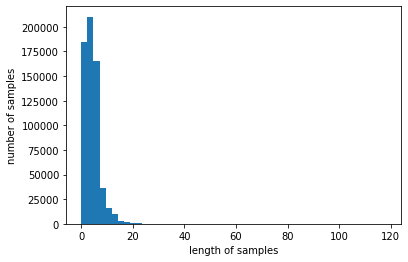

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 15
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 15 이하인 샘플의 비율: 99.15484627932044


In [ ]:
X = pad_sequences(data['내용인덱스'], maxlen = max_len)

In [ ]:
xt = pd.DataFrame(X)

In [ ]:
train = pd.concat([xt,onehot_data], axis=1, join='outer')

In [ ]:
del train['내용인덱스']

In [ ]:
train.iloc[:,126]

0         0
1         0
2         0
3         0
4         0
         ..
628993    0
628994    0
628995    0
628996    0
628997    0
Name: 쌀/잡곡, Length: 628998, dtype: int64

In [ ]:
word = pd.read_csv('/content/drive/My Drive/단어사전.csv')

In [ ]:
word

,Unnamed: 0,0
0,버스,1
1,깔창,2
2,후드,3
3,표고버섯,4
4,수입,5
...,...,...
7555,중학,7556
7556,반려견,7557
7557,프레그런스,7558
7558,옵티멈뉴트리션,7559


In [ ]:
train.to_csv('/content/drive/My Drive/최종.csv')

In [ ]:
train = pd.read_csv('/content/drive/My Drive/최종.csv',index_col=0)

In [ ]:
train.iloc[:,49]

0         0
1         0
2         0
3         0
4         0
         ..
628993    0
628994    0
628995    0
628996    0
628997    0
Name: 구기스포츠, Length: 628998, dtype: int64

train, test 데이터 분리

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train.iloc[:,:15],train.iloc[:,15:],test_size=0.2,random_state=0)

In [ ]:
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
548820,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50249,0,0,0,0,0,0,0,0,1994,6409,6771,4858,5108,5125,3489
64183,0,0,0,0,0,0,1685,3534,4142,3904,4363,3738,1988,5102,235
405148,0,0,0,0,0,0,0,0,0,0,0,6962,2038,6692,2764
510825,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4321
152315,0,0,0,0,0,0,0,0,0,7265,1940,541,4403,4410,104
117952,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4172
435829,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1171


모델 학습

In [ ]:
model = Sequential()
model.add(Embedding(7561, 120))
model.add(LSTM(120))
model.add(Dense(191, activation='softmax'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
history = model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=60, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/60
6709/6710 [============================>.] - ETA: 0s - loss: 2.1291 - acc: 0.5218
Epoch 00001: val_acc improved from -inf to 0.60908, saving model to best_model.h5
6710/6710 [==============================] - 60s 9ms/step - loss: 2.1290 - acc: 0.5218 - val_loss: 1.6303 - val_acc: 0.6091
Epoch 2/60
6708/6710 [============================>.] - ETA: 0s - loss: 1.5169 - acc: 0.6288
Epoch 00002: val_acc improved from 0.60908 to 0.62563, saving model to best_model.h5
6710/6710 [==============================] - 59s 9ms/step - loss: 1.5168 - acc: 0.6288 - val_loss: 1.5363 - val_acc: 0.6256
Epoch 3/60
6710/6710 [==============================] - ETA: 0s - loss: 1.4060 - acc: 0.6470
Epoch 00003: val_acc improved from 0.62563 to 0.63262, saving model to best_model.h5
6710/6710 [==============================] - 59s 9ms/step - loss: 1.4060 - acc: 0.6470 - val_loss: 1.4981 - val_acc: 0.6326
Epoch 4/60
6709/6710 [============================>.] - ETA: 0s - loss: 1.3300 - acc: 0.6615
Epoc

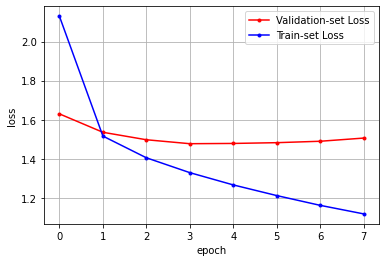

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
loaded_model = load_model('/content/drive/My Drive/best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

NameError: ignored

In [ ]:
test = pd.read_csv('/content/test.csv')

In [ ]:
test = test[['중분류','내용']]

텍스트를 인덱스 값으로 변환시켜주는 함수

In [ ]:
loaded_model = load_model('/content/drive/My Drive/best_model.h5')

def word_encoding(stri):
  st = []
  only_han = re.sub('[^가-힣]', ' ', stri).split()
  st.append(only_han)
  word_table = pd.read_csv('/content/drive/My Drive/단어사전.csv',index_col=0)
  word_table = word_table.to_dict('dict')['0']
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(word_table)
  only_han = tokenizer.texts_to_sequences(st)
  X = pad_sequences(only_han, maxlen = 15)
  return X
def prediction(word):
  arr = word_encoding(word)
  a = np.argmax(loaded_model.predict(arr),axis=1).reshape(-1,1)
  return class_name[a[0][0]]

word = '모니터'
print(prediction(word))


array([[171]])

In [ ]:
word_encoding('모니터')

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0, 234]], dtype=int32)

In [ ]:
loaded_model = load_model('/content/drive/My Drive/best_model.h5')

def word_encoding(stri):
  st = []
  only_han = re.sub('[^가-힣]', ' ', stri).split()
  st.append(only_han)
  word_table = pd.read_csv('/content/drive/My Drive/단어사전.csv',index_col=0)
  word_table = word_table.to_dict('dict')['0']
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(word_table)
  only_han = tokenizer.texts_to_sequences(st)
  X = pad_sequences(only_han, maxlen = 15)
  return X
def prediction(word):
  arr = word_encoding(word)
  a = np.argmax(loaded_model.predict(arr),axis=1).reshape(-1,1)
  return class_name[a[0][0]]

word = '모니터'
print(prediction(word))

'콘솔/게이밍PC'

In [ ]:
a[0][0]

111

In [ ]:
df = pd.read_csv('/content/drive/My Drive/최종.csv',index_col = 0)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,1인방송 전문관,F/W 침구샵,RC완구/부품,STEAM완구,TV/영상가전,가구,가루/조미료/오일,가방/잡화,가정 살림,강아지_영양제,강아지_용품,강아지간식,강아지사료,건강 취미,건강_의료용품,건강가전,건강도서,건강식품,건강즙,견과/건과,경제 경영,고양이_간식,고양이_사료,고양이_영양제,...,차량용 디지털,차량용디지털,채소,청소/주방세제,초중고참고서,축산/계란,침구,카드_엽서_봉투,카메라,카시트,카페트/쿠션/거실화,칼/도마,캐릭터_문구,캐릭터별완구,캠핑전문관,커튼/블라인드,커피/원두/차,커피/티/와인,컴퓨터,컵/잔/텀블러,콘솔/게이밍PC,클렌징/필링,킥보드/스케이트,탈취/방향/살충,파티_이벤트,퍼즐/큐브/피젯토이,프라모델,필기류,학습완구/교구,학용품_수업준비,향수,헤어,헬스/요가/댄스,헬스_요가용품,헬스보충식품,홈데코,홈트레이닝,홍삼_인삼,화장지/물티슈,휴대폰/액세서리
0,0,0,0,0,0,0,0,0,0,0,0,0,3876,4958,3475,5504,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,0,0,3876,4958,3475,104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2923,6206,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,0,0,0,0,0,0,0,0,0,0,3876,4958,2672,3475,6692,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,4,0,0,0,0,0,0,0,0,0,0,0,0,1144,3475,3549,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628993,628993,0,0,0,0,0,0,0,0,0,0,0,6974,1471,3949,3405,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
628994,628994,0,0,0,0,0,0,0,0,0,6974,1471,6208,6208,6051,5894,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
628995,628995,0,0,0,0,0,0,0,0,0,0,0,6974,1471,2046,4005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
628996,628996,0,0,0,0,0,0,0,0,0,0,0,0,0,1561,6118,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
a = word_encoding('아디다스 스포츠백팩 신발주머니 보조가방, 블랙DQ1068')

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 4321, 6692]], dtype=int32)

In [ ]:
one_hot = df.iloc[:,16:]

In [ ]:
class_name = {}

In [ ]:
idx=0
for i in one_hot.columns:
  class_name[idx] = i
  idx += 1

In [ ]:
test

,중분류,내용
0,스포츠패션,"아디다스 스포츠백팩 신발주머니 보조가방, 블랙DQ1068"
1,스포츠패션,"아디다스 스포츠백팩 신발주머니 보조가방, 블랙DQ1068"
2,스포츠패션,"팬톤 편광클립 스포츠 선글라스 클립렌즈 RFU13 + 케이스 + 파우치, 블루"
3,생활가전,"현대모비스 차량용 에어컨 히터 습기건조기, HMED-01"
4,생활가전,"필립스 일반형 아주르 어드밴스드 스팀 다리미, GC4938/20, 혼합 색상"
5,강아지용품,"새끼강아지 급체방지 식기 슬로우 밥그릇 블루, 1개"
6,강아지용품,"딩동펫 반려동물 디스펜서 베이직 물병 S, 핑크, 1개"
7,영양제,현미 발효쌀눈효소 실버플러스 30포
8,영양제,나우푸드 Now Foods NutraFlora FOS 순수 파우더 4oz(113g)...


In [ ]:
stopwords = ['외','의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()
X_train = []
for sentence in df['적요']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [ ]:
train = pd.read_csv('/content/drive/My Drive/최종.csv',index_col=0)

In [ ]:
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,1인방송 전문관,F/W 침구샵,RC완구/부품,STEAM완구,TV/영상가전,가구,가루/조미료/오일,가방/잡화,가정 살림,강아지_영양제,강아지_용품,강아지간식,강아지사료,건강 취미,건강_의료용품,건강가전,건강도서,건강식품,건강즙,견과/건과,경제 경영,고양이_간식,고양이_사료,고양이_영양제,고양이_용품,...,차량용 디지털,차량용디지털,채소,청소/주방세제,초중고참고서,축산/계란,침구,카드_엽서_봉투,카메라,카시트,카페트/쿠션/거실화,칼/도마,캐릭터_문구,캐릭터별완구,캠핑전문관,커튼/블라인드,커피/원두/차,커피/티/와인,컴퓨터,컵/잔/텀블러,콘솔/게이밍PC,클렌징/필링,킥보드/스케이트,탈취/방향/살충,파티_이벤트,퍼즐/큐브/피젯토이,프라모델,필기류,학습완구/교구,학용품_수업준비,향수,헤어,헬스/요가/댄스,헬스_요가용품,헬스보충식품,홈데코,홈트레이닝,홍삼_인삼,화장지/물티슈,휴대폰/액세서리
0,0,0,0,0,0,0,0,0,0,0,0,3876,4958,3475,5504,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,3876,4958,3475,104,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,2923,6206,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,3876,4958,2672,3475,6692,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,1144,3475,3549,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628993,0,0,0,0,0,0,0,0,0,0,0,6974,1471,3949,3405,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
628994,0,0,0,0,0,0,0,0,0,6974,1471,6208,6208,6051,5894,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
628995,0,0,0,0,0,0,0,0,0,0,0,6974,1471,2046,4005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
628996,0,0,0,0,0,0,0,0,0,0,0,0,0,1561,6118,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train.iloc[:,:15],train.iloc[:,15:],test_size=0.2,random_state=0)

In [ ]:
model = Sequential()
model.add(Embedding(7561, 64))
model.add(Dropout(0.2))
model.add(Conv1D(32,5, strides=1, padding='valid',activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(191, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          483904    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          10272     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 191)              

In [ ]:
es = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=3)
mc = ModelCheckpoint('1027best_model.h5',monitor='val_acc',mode='max',verbose=1,save_best_only=True)
history = model.fit(x_train, y_train,validation_data=(x_test, y_test), epochs=60, callbacks=[mc], batch_size=60, validation_split=0.2)

Epoch 1/60
6708/6710 [============================>.] - ETA: 0s - loss: 2.8614 - acc: 0.3741
Epoch 00001: val_acc improved from -inf to 0.55363, saving model to 1027best_model.h5
6710/6710 [==============================] - 46s 7ms/step - loss: 2.8613 - acc: 0.3742 - val_loss: 1.9953 - val_acc: 0.5536
Epoch 2/60
6708/6710 [============================>.] - ETA: 0s - loss: 2.0306 - acc: 0.5411
Epoch 00002: val_acc improved from 0.55363 to 0.57933, saving model to 1027best_model.h5
6710/6710 [==============================] - 45s 7ms/step - loss: 2.0307 - acc: 0.5411 - val_loss: 1.8270 - val_acc: 0.5793
Epoch 3/60
6703/6710 [============================>.] - ETA: 0s - loss: 1.8897 - acc: 0.5649
Epoch 00003: val_acc improved from 0.57933 to 0.59150, saving model to 1027best_model.h5
6710/6710 [==============================] - 45s 7ms/step - loss: 1.8897 - acc: 0.5649 - val_loss: 1.7609 - val_acc: 0.5915
Epoch 4/60
6707/6710 [============================>.] - ETA: 0s - loss: 1.8181 - acc:

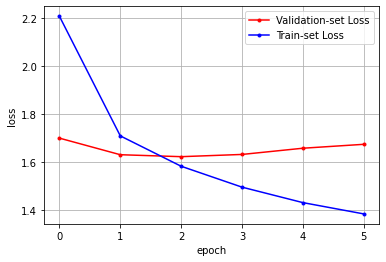

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
 loaded_model = load_model('/content/1027best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))  

3932/3932 [==============================] - 6s 2ms/step - loss: 1.6242 - acc: 0.6255

 테스트 정확도: 0.6255


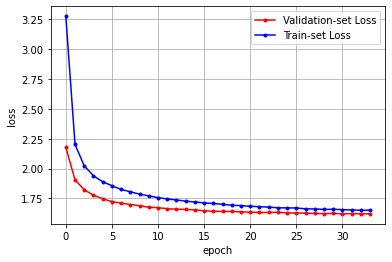

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
loaded_model = load_model('/content/drive/My Drive/best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(x_test, y_test)[1]))

3932/3932 [==============================] - 11s 3ms/step - loss: 1.4829 - acc: 0.6430

 테스트 정확도: 0.6430


In [ ]:
cotent = pd.read_csv('/content/drive/My Drive/단어사전.csv')

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

In [ ]:
tokenizer.word_index

In [ ]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
enc.fit(Y_class)

FileNotFoundError: ignored

In [ ]:
X = dd['내용_y']
Xw

0             ['삼성전자 갤럭시 S20 FE
0                           공기계
0                      클라우드 라벤더
0                        128GB'
0              '삼성전자 갤럭시 S20 FE
                ...            
13                        1 파랑'
13       '사무용 수동 문서세단기 / 문서파쇄기'
13     '전통스타일 코스프레 레드 포인트 왕관 소품
13                            개
13                          E']
Name: 내용_y, Length: 2006619, dtype: object

In [ ]:
Y = dd['중분류']
Y

0     휴대폰/액세서리
0     휴대폰/액세서리
0     휴대폰/액세서리
0     휴대폰/액세서리
0     휴대폰/액세서리
        ...   
13    보드_칠판_광고
13    보드_칠판_광고
13    보드_칠판_광고
13    보드_칠판_광고
13    보드_칠판_광고
Name: 중분류, Length: 2006619, dtype: object

In [ ]:
qq = dd[['대분류','내용']]

In [ ]:
qq

,대분류,내용
0,가전디지털,"[삼성전자, 갤럭시, 공기계, 클라우드, 라벤더]"
1,가전디지털,"[삼성전자, 갤럭시, 공기계, 클라우드, 레드]"
2,가전디지털,"[년, 세대]"
3,가전디지털,"[삼성전자, 갤럭시, 휴대폰, 공기계, 프리즘, 크러시, 블랙]"
4,가전디지털,"[샤오미, 홍미노트, 자급제, 새상품, 공기계, 화이트]"
...,...,...
604414,문구&오피스,"[개묶음, 할인, 컬러, 인덱스, 명함케이스, 명함보관집, 쿠폰정리, 데스크명함박스..."
604415,문구&오피스,"[개묶음, 할인, 메모꽂이, 집게, 집게, 대형, 꽂이, 깔끔한메모꽂이, 메모집게]"
604416,문구&오피스,"[개묶음, 할인, 색동, 비단, 누빔, 펜슬케이스, 펜슬파우치, 선물용필통, 비단필..."
604417,문구&오피스,"[사무용, 수동, 문서세단기, 문서파쇄기]"


In [ ]:
q.set_index('대분류').to_dict('list')

{'내용': [['삼성전자', '갤럭시', '공기계', '클라우드', '라벤더'],
  ['삼성전자', '갤럭시', '공기계', '클라우드', '레드'],
  ['년', '세대'],
  ['삼성전자', '갤럭시', '휴대폰', '공기계', '프리즘', '크러시', '블랙'],
  ['샤오미', '홍미노트', '자급제', '새상품', '공기계', '화이트'],
  ['엘지폴더폰', '학생폰', '효도폰', '새제품', '무약정', '블랙', '엘지폴더폰'],
  ['년',
   '월출시',
   '엘지폴더폰',
   '학생폰',
   '효도폰',
   '공신폰',
   '새제품',
   '무약정',
   '블랙그레이',
   '엘지폴더폰',
   '목줄',
   '케이스',
   '필름증정'],
  ['삼성', '갤럭시와이드', '갤럭시', '가개통', '미사용', '새제품', '공기계', '골드'],
  ['샤오미', '홍미노트', '자급제', '새상품', '공기계', '그레이'],
  ['듀얼스크린', '등급'],
  ['전자', '휴대폰', '뉴', '오로라', '블랙']]}

In [ ]:
q = qq.loc[:10]

In [ ]:
q = q.set_index('대분류')